In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
# from proglearn.sims import generate_gaussian_parity

In [2]:
from sklearn.datasets import make_blobs


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    angle_params=None,
    random_state=None,
):
    """
    Generate 2-dimensional Gaussian XOR distribution.
    (Classic XOR problem but each point is the
    center of a Gaussian blob distribution)

    Parameters
    ----------
    n_samples : int
        Total number of points divided among the four
        clusters with equal probability.

    centers : array of shape [n_centers,2], optional (default=None)
        The coordinates of the ceneter of total n_centers blobs.

    class_label : array of shape [n_centers], optional (default=None)
        class label for each blob.

    cluster_std : float, optional (default=1)
        The standard deviation of the blobs.

    angle_params: float, optional (default=None)
        Number of radians to rotate the distribution by.

    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.


    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y


# Simulation Data Generation


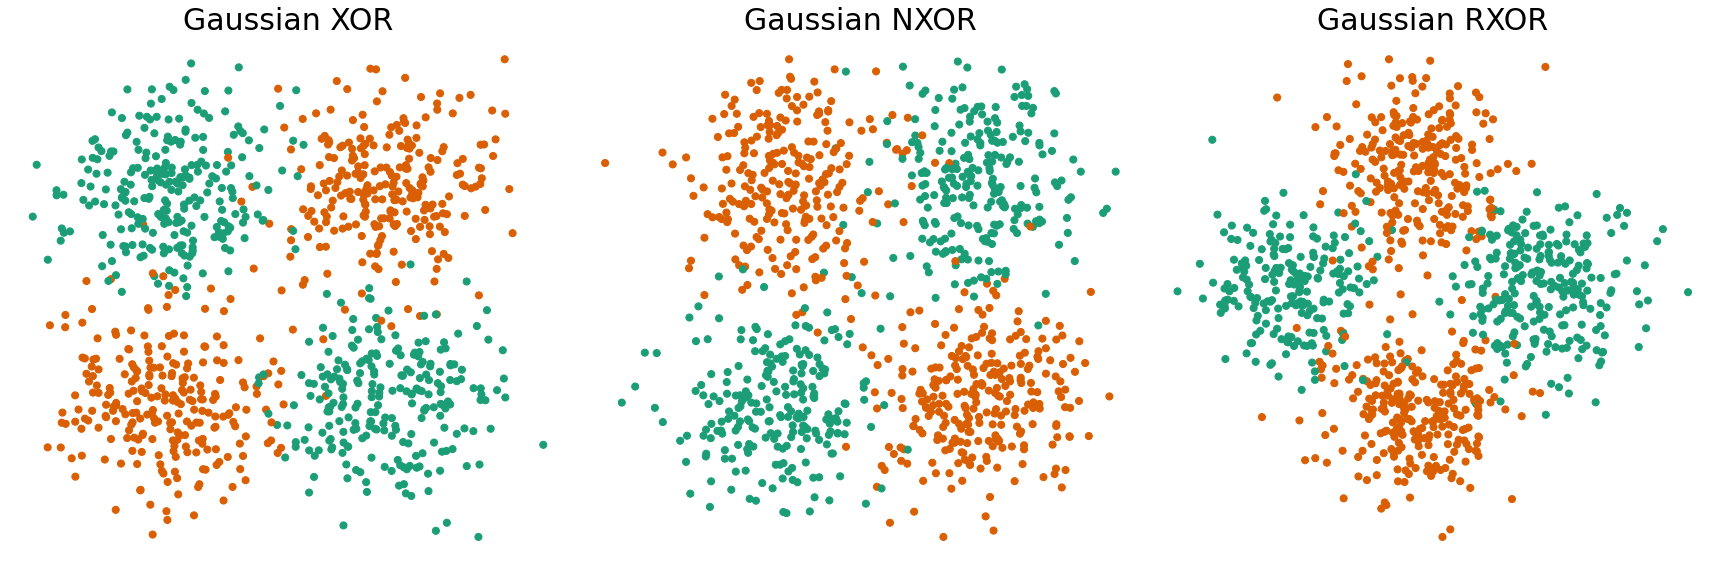

In [3]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_nxor, y_nxor = generate_gaussian_parity(1000, angle_params=np.pi/2)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)

colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_nxor]
ax[1].scatter(X_nxor[:, 0], X_nxor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian NXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian RXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

# Experiment definition

In [4]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None):

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2=progressive_learner.predict(test_task2,
                                             transformer_ids=[0], task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        
        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1,
                                     num_transformers=n_trees)

        uf_task1=progressive_learner.predict(test_task1, 
                                             transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        
        errors[2] = 0.5
        errors[3] = 0.5
        
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
        uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
        naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
        naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
        naive_uf.add_task(
                naive_uf_train_x, naive_uf_train_y, num_transformers=n_trees
                )
        
        uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)
        uf_task2=uf.predict(test_task2, transformer_ids=[1], task_id=1)
        l2f_task2=progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(
            test_task1, transformer_ids=[0], task_id=0
        )
        naive_uf_task2 = naive_uf.predict(
            test_task2, transformer_ids=[0], task_id=0
        )

        errors[0] = 1 - np.mean(
            uf_task1 == test_label_task1
        )
        errors[1] = 1 - np.mean(
            l2f_task1 == test_label_task1
        )
        errors[2] = 1 - np.mean(
            uf_task2 == test_label_task2
        )
        errors[3] = 1 - np.mean(
            l2f_task2 == test_label_task2
        )
        errors[4] = 1 - np.mean(
            naive_uf_task1 == test_label_task1
        )
        errors[5] = 1 - np.mean(
            naive_uf_task2 == test_label_task2
        )

    return errors


# Run experiment for XOR R-XOR tasks

In [5]:
mc_rep = 50
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_rxor)))
std_error = np.zeros((6, len(n_xor)+len(n_rxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_rxor)))
std_te = np.zeros((4, len(n_xor)+len(n_rxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,task2_angle=np.pi/4,
            max_depth=ceil(log2(750))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_rxor):
            print('starting to compute %s rxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,task2_angle=np.pi/4,
                    max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./data/mean_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./data/std_xor_rxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./data/mean_te_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_te,f)

starting to compute 50 xor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 75 xor

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 100 xor

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 125 xor

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 150 xor

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 conc

# Plot XOR R-XOR results

Text(900, 0.7255994536877134, 'R-XOR')

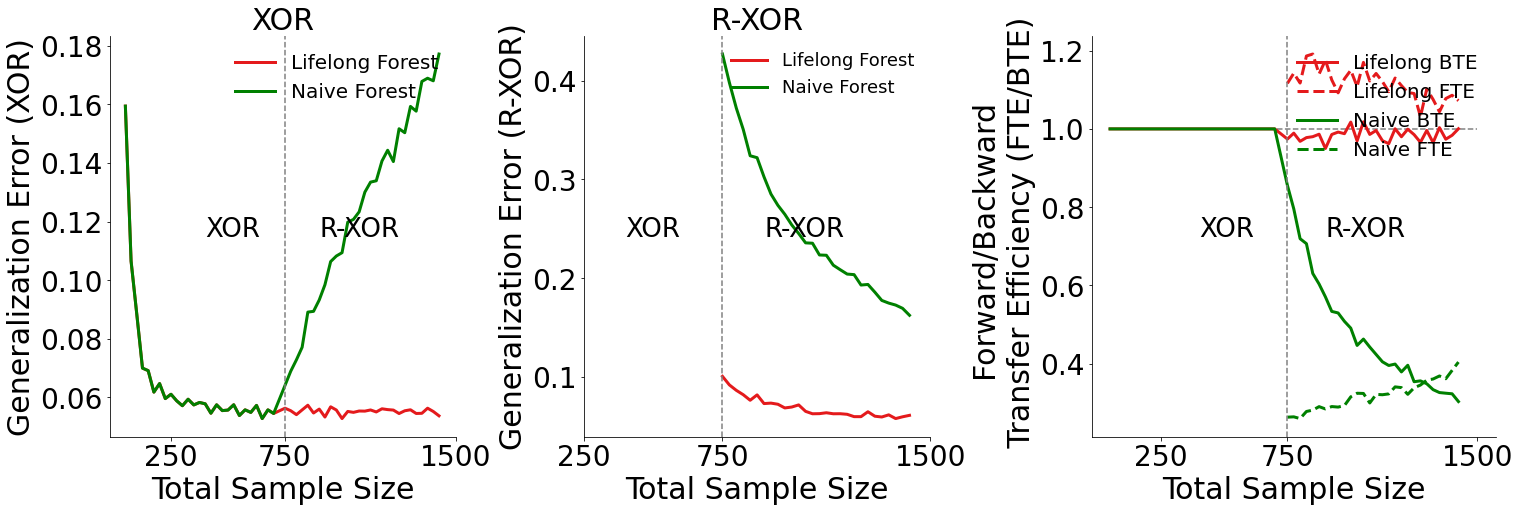

In [11]:
with open('data/mean_xor_rxor.pickle','rb') as f:
    mean_error = pickle.load(f)

n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='XOR'
TASK2='R-XOR'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 2)

fig = plt.figure(constrained_layout=True,figsize=(21,7))
gs = fig.add_gridspec(7,21)
ax1 = fig.add_subplot(gs[:,:6])
# ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
# ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.1,0.15, 0.2])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

#####################################
ax1 = fig.add_subplot(gs[:,7:13])
# ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
# ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', ls=ls[0], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('R-XOR', fontsize=30)

#####################################
with open('data/mean_te_xor_rxor.pickle','rb') as f:
    mean_te = pickle.load(f)

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

ax1 = fig.add_subplot(gs[:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

## image version

In [18]:
def coord_to_image(X, y, len_img):
    X = (X * 10 + 20).astype(int)
    img = np.zeros((len_img,len_img)).astype(int)
    for i in range(len(X)):
        i0 = X[i,0].astype(int)
        j0 = X[i,1].astype(int)
        if img[i0,j0] == 0:
            if y[i] == 0:
                img[i0,j0] = -1
            else:
                img[i0,j0] = 1
    
    return img


In [21]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None):

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    len_img = 50
    X_task1 = np.zeros((n_task1, len_img*len_img))
    y_task1 = np.zeros((n_task1,))
    X_task2 = np.zeros((n_task2, len_img*len_img))
    y_task2 = np.zeros((n_task2,))
    test_task1 = np.zeros((n_test, len_img*len_img))
    test_label_task1 = np.zeros((n_test,))
    test_task2 = np.zeros((n_test, len_img*len_img))
    test_label_task2 = np.zeros((n_test,))
    #source data
    for n0 in range(n_task1):
        X_task1_temp, y = generate_gaussian_parity(n_task1, angle_params=task1_angle)
        X_task1_temp = coord_to_image(X_task1_temp, y, len_img).reshape((1,-1))
        # print(X_task1_temp.shape)
        X_task1[n0,:] = X_task1_temp
        y_task1[n0] = 0

    #target data  
    for n0 in range(n_task2):
        X_task2_temp, y = generate_gaussian_parity(n_task2, angle_params=task2_angle)
        X_task2_temp = coord_to_image(X_task2_temp, y, len_img).reshape((1,-1))
        X_task2[n0,:] = X_task2_temp
        y_task2[n0] = 1

    # test data
    for n0 in range(n_test):
        test_task1_temp, y = generate_gaussian_parity(n_test, angle_params=task1_angle)
        test_task1_temp = coord_to_image(test_task1_temp, y, len_img).reshape((1,-1))
        test_task1[n0,:] = test_task1_temp
        test_label_task1[n0] = 0
        test_task2_temp,_ = generate_gaussian_parity(n_test, angle_params=task2_angle)
        test_task2_temp = coord_to_image(test_task2_temp, y, len_img).reshape((1,-1))
        test_task2[n0,:] = test_task2_temp
        test_label_task2[n0] = 1
 

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2=progressive_learner.predict(test_task2,
                                             transformer_ids=[0], task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        
        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1,
                                     num_transformers=n_trees)

        uf_task1=progressive_learner.predict(test_task1, 
                                             transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        
        errors[2] = 0.5
        errors[3] = 0.5
        
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
        uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
        naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
        naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
        naive_uf.add_task(
                naive_uf_train_x, naive_uf_train_y, num_transformers=n_trees
                )
        
        uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)
        uf_task2=uf.predict(test_task2, transformer_ids=[1], task_id=1)
        l2f_task2=progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(
            test_task1, transformer_ids=[0], task_id=0
        )
        naive_uf_task2 = naive_uf.predict(
            test_task2, transformer_ids=[0], task_id=0
        )

        errors[0] = 1 - np.mean(
            uf_task1 == test_label_task1
        )
        errors[1] = 1 - np.mean(
            l2f_task1 == test_label_task1
        )
        errors[2] = 1 - np.mean(
            uf_task2 == test_label_task2
        )
        errors[3] = 1 - np.mean(
            l2f_task2 == test_label_task2
        )
        errors[4] = 1 - np.mean(
            naive_uf_task1 == test_label_task1
        )
        errors[5] = 1 - np.mean(
            naive_uf_task2 == test_label_task2
        )

    return errors


In [22]:
mc_rep = 1
n_test = 1000
n_trees = 10
# n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
# n_rxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)
n_xor = (100*np.arange(0.5, 7.25, step=1)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=1)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_rxor)))
std_error = np.zeros((6, len(n_xor)+len(n_rxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_rxor)))
std_te = np.zeros((4, len(n_xor)+len(n_rxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,task2_angle=np.pi/4,
            max_depth=ceil(log2(750))
        ) for _ in range(mc_rep)
      )
    )
    print("pass")
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_rxor):
            print('starting to compute %s rxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,task2_angle=np.pi/4,
                    max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./data/img_mean_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./data/img_std_xor_rxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./data/img_mean_te_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_te,f)

starting to compute 50 xor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
pass
starting to compute 150 xor

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
pass
starting to compute 250 xor

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
pass
starting to compute 350 xor

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
pass
starting to compute 450 xor

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
pass
starting to compute 

In [31]:
# with open('data/img_mean_xor_rxor.pickle','rb') as f:
#     mean_error = pickle.load(f)

# n_xor = (100*np.arange(0.5, 7.25, step=1)).astype(int)
# n_nxor = (100*np.arange(0.5, 7.50, step=1)).astype(int)

# n1s = n_xor
# n2s = n_nxor

# ns = np.concatenate((n1s, n2s + n1s[-1]))
# ls=['-', '--']
# algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']


# TASK1='XOR'
# TASK2='R-XOR'

# fontsize=30
# labelsize=28

# colors = sns.color_palette("Set1", n_colors = 2)

# fig = plt.figure(constrained_layout=True,figsize=(21,7))
# gs = fig.add_gridspec(7,21)
# ax1 = fig.add_subplot(gs[:,:6])
# # ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
# # ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)
# ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
# ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

# ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
# ax1.legend(loc='upper right', fontsize=20, frameon=False)
# #ax1.set_ylim(0.09, 0.21)
# ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
# ax1.tick_params(labelsize=labelsize)
# #ax1.set_yticks([0.1,0.15, 0.2])
# ax1.set_xticks([250,650,1300])
# ax1.axvline(x=650, c='gray', linewidth=1.5, linestyle="dashed")
# ax1.set_title('XOR', fontsize=30)

# right_side = ax1.spines["right"]
# right_side.set_visible(False)
# top_side = ax1.spines["top"]
# top_side.set_visible(False)

# ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
# ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

# #####################################
# ax1 = fig.add_subplot(gs[:,7:13])
# # ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
# # ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)

# ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], ls=ls[0], lw=3)
# ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', ls=ls[0], lw=3)

# ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
# ax1.legend(loc='upper right', fontsize=18, frameon=False)
# ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
# ax1.tick_params(labelsize=labelsize)
# ax1.set_xticks([250,650,1300])
# ax1.axvline(x=650, c='gray', linewidth=1.5, linestyle="dashed")


# right_side = ax1.spines["right"]
# right_side.set_visible(False)
# top_side = ax1.spines["top"]
# top_side.set_visible(False)

# ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
# ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

# ax1.set_title('R-XOR', fontsize=30)

# #####################################
# with open('data/img_mean_te_xor_rxor.pickle','rb') as f:
#     mean_te = pickle.load(f)

# algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

# ax1 = fig.add_subplot(gs[:,14:])

# ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
# ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
# ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
# ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

# ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
# ax1.legend(loc='upper right', fontsize=20, frameon=False)
# ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
# ax1.tick_params(labelsize=labelsize)
# #ax1.set_yticks([0,.5,1,1.5])
# ax1.set_xticks([250,650,1300])
# ax1.axvline(x=650, c='gray', linewidth=1.5, linestyle="dashed")
# right_side = ax1.spines["right"]
# right_side.set_visible(False)
# top_side = ax1.spines["top"]
# top_side.set_visible(False)
# ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

# ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
# ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)